In [ ]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.6/720.6 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 19.1 MB/s eta 0:00:00


# AutoEncoder using CIFAR10 dataset

## Imports

In [ ]:

import numpy as np
import torch
import torch.nn as nn

import pytorch_lightning as pl
import torchvision
from torchvision.datasets import MNIST, CIFAR10
import os

from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import StepLR

## Encoder

In [ ]:

class Encoder(nn.Module):
  # TODO: add the linear dimension to the argument
  def __init__(self, input_channels, output_channels, linear_dim):
    super().__init__()
    self.linear_dim = linear_dim
    self.output_channels = output_channels
    self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1)
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(2,2)
    self.linear = nn.Linear(192, linear_dim)
    # TODO: add a linear layer after flattening the output of relu2


  def forward(self, x):
    x = self.conv(x)
    x = self.relu(x)
    x = self.pool(x)
    x = self.conv(x)
    x = self.relu(x)
    x = self.pool(x)
    x = nn.Flatten()(x)
    x = self.linear(x)
    return x





## Decoder

In [ ]:

class Decoder(nn.Module):
  # TODO: add the linear dimension to the argument
  def __init__(self, input_channels, output_channels, linear_dim):
    super().__init__()
    self.linear = nn.Linear(linear_dim, linear_dim)
    self.relu = nn.ReLU()
    self.deconv = nn.ConvTranspose2d(output_channels, input_channels, kernel_size=3, padding=1)

  def forward(self, z):
    # TODO: reshape z before using cnn, knowing that the output of the encoder now is a vector after the linear operator
    x = self.linear(z)
    x = self.relu(x)
    x = x.view(x.size(0),3,32,32) # TODO: hard coded values make it dynamic since you know the latent dim
    x = self.deconv(x)
    x = self.relu(x)
    x = self.deconv(x)
    x = self.relu(x)
    return x


## AutoEncoder

In [ ]:

# Create a PyTorch Lightning class
class AutoEncoder(pl.LightningModule):
    def __init__(self, input_channels, output_channels, linear_dim):
        super().__init__()
        self.input_shape = input_channels
        self.num_hidden = output_channels
        self.latent_dim = linear_dim
        self.encoder = Encoder(input_channels, output_channels, linear_dim)
        self.decoder = Decoder(input_channels, output_channels, linear_dim)

    def forward(self, x):
        # Forward pass
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def configure_optimizers(self):
        # TODO: add StepLR learning rate scheduler
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        schedduler = StepLR(optimizer, step_size=30, gamma=0.1)
        return [optimizer], [schedduler]


    def add_noise(self, x):
        # Add random noise
        noise = torch.randn_like(x)
        x_noisy = x + noise
        return x_noisy

    def training_step(self, batch, batch_idx):
        # Training step
        x, y = batch
        x_noisy = self.add_noise(x)
        z = self.encoder(x_noisy)
        x_hat = self.decoder(z)
        loss = nn.functional.mse_loss(x_hat, x)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        # Validation step
        x, y = batch
        x_noisy = self.add_noise(x)
        z = self.encoder(x_noisy)
        x_hat = self.decoder(z)
        loss = nn.functional.mse_loss(x_hat, x)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Testing step
        x, y = batch
        x_noisy = self.add_noise(x)
        z = self.encoder(x_noisy)
        x_hat = self.decoder(z)
        loss = nn.functional.mse_loss(x_hat, x)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        # Plot the first 8 images in the batch
        if batch_idx == 0:
            self.original = x[:8]
            self.images_noisy = x_noisy[:8]
            self.reconstructions = x_hat[:8]
        return loss

    # final step after training to print original images and the results in the latent space
    def on_test_end(self):
      for i, (im, recon, origin) in enumerate(zip(self.images_noisy, self.reconstructions, self.original)):
        im = im.permute(1, 2, 0)
        recon = recon.permute(1, 2, 0)
        origin = origin.permute(1,2,0)

        plt.subplot(8, 3, i * 3 + 1)
        if i == 0:
            plt.title("Original Image")
        plt.imshow(origin.detach().cpu().numpy())
        plt.axis("off")

        plt.subplot(8, 3, i * 3 + 2)
        if i == 0:
            plt.title("Image with noise")
        plt.imshow(im.detach().cpu().numpy())
        plt.axis("off")

        plt.subplot(8, 3, i * 3 + 3)
        if i == 0:
            plt.title("Reconstruction")
        plt.imshow(recon.detach().cpu().numpy())
        plt.axis("off")

    plt.show()




## DataModule

In [ ]:
#TODO: Use Tiny ImageNet dataset with 128x128 image
#TODO: add resize in the transform table, to resize the images to 128x128

# Create the datamodule for CIFAR-10 dataset
class CIFAR10DataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str = "./", batch_size=32):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                        torchvision.transforms.Normalize((0.1307,), (0.3081,))])


    def prepare_data(self):
        # download
        CIFAR10(self.data_dir, train=True, download=True)
        CIFAR10(self.data_dir, train=False, download=True)


    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            CIFAR10(root=".", train=True, transform=self.transform),
            batch_size=self.batch_size,
            shuffle=True,
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            CIFAR10(root=".", train=False, transform=self.transform),
            batch_size=self.batch_size,
            shuffle=False,
        )

    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            CIFAR10(root=".", train=False, transform=self.transform),
            batch_size=self.batch_size,
            shuffle=False,
        )

    def setup(self, stage: str):
        # Assign train/val datasets for use in dataloaders
        if stage == "fit":
            self.cifar10_train = self.train_dataloader()
            # split data into train and validation
            self.cifar10_val = self.val_dataloader()

        # Assign test dataset for use in dataloader(s)
        if stage == "test":
            self.cifar10_test = self.test_dataloader()


## Training

In [ ]:
# Create the model
model = AutoEncoder(input_channels=3, output_channels=3 , linear_dim=3072)
dataset = CIFAR10DataModule(data_dir = os.getcwd(), batch_size=32)
trainer = pl.Trainer(max_epochs=20, accelerator="gpu", devices=-1)
trainer.fit(model, dataset)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 592 K 
1 | decoder | Decoder | 9.4 M 
------------------------------------
10.0 M    Trainable params
0         Non-trainable params
10.0 M    Total params
40.133    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


## Test

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:148: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(


Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_1/checkpoints/epoch=19-step=31260.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_1/checkpoints/epoch=19-step=31260.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.11125849932432175    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.11125849932432175}]

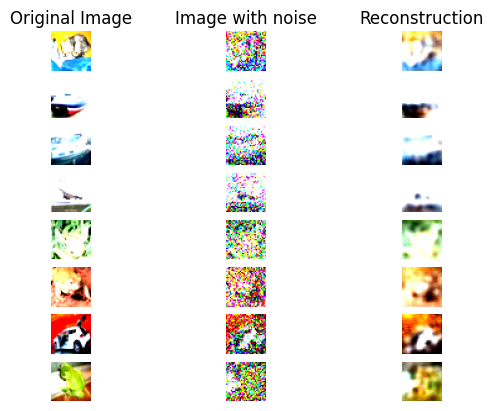

In [ ]:
dataset.setup(stage="test")
trainer.test(datamodule=dataset)
